### This jupyter notebooks provides the code for classifying signals using DCT and various DWTs, with various lengths of truncation.

In [26]:
import os
from time import perf_counter
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pywt
from collections import defaultdict, Counter
from scipy import signal

import keras
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Flatten, Activation
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import Sequential
from keras.callbacks import History, EarlyStopping
from sklearn.metrics import confusion_matrix

import pdb
history = History()

# 1. Loading the UCI HAR dataset
Download the dataset from https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

In [24]:
activities_description = {
    0: 'walking',
    1: 'walking upstairs',
    2: 'walking downstairs',
    3: 'sitting',
    4: 'standing',
    5: 'laying'
}

def read_signals(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
    return data

def read_labels(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(lambda x: int(x)-1, activities))
    return activities

def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

DATA_FOLDER = '../datasets/UCI HAR Dataset/'
INPUT_FOLDER_TRAIN = DATA_FOLDER+'train/Inertial Signals/'
INPUT_FOLDER_TEST = DATA_FOLDER+'test/Inertial Signals/'

INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                     'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']

INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
                     'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']

LABELFILE_TRAIN = DATA_FOLDER+'train/y_train.txt'
LABELFILE_TEST = DATA_FOLDER+'test/y_test.txt'

train_signals, test_signals = [], []

for input_file in INPUT_FILES_TRAIN:
    signal = read_signals(INPUT_FOLDER_TRAIN + input_file)
    train_signals.append(signal)
train_signals = np.transpose(np.array(train_signals), (1, 2, 0))

for input_file in INPUT_FILES_TEST:
    signal = read_signals(INPUT_FOLDER_TEST + input_file)
    test_signals.append(signal)
test_signals = np.transpose(np.array(test_signals), (1, 2, 0))

train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)

[no_signals_train, no_steps_train, no_components_train] = np.shape(train_signals)
[no_signals_test, no_steps_test, no_components_test] = np.shape(train_signals)
no_labels = len(np.unique(train_labels[:]))

print("The train dataset contains {} signals, each one of length {} and {} components ".format(no_signals_train, no_steps_train, no_components_train))
print("The test dataset contains {} signals, each one of length {} and {} components ".format(no_signals_test, no_steps_test, no_components_test))
print("The train dataset contains {} labels, with the following distribution:\n {}".format(np.shape(train_labels)[0], Counter(train_labels[:])))
print("The test dataset contains {} labels, with the following distribution:\n {}".format(np.shape(test_labels)[0], Counter(test_labels[:])))

uci_har_signals_train, uci_har_labels_train = randomize(train_signals, np.array(train_labels))
uci_har_signals_test, uci_har_labels_test = randomize(test_signals, np.array(test_labels))

The train dataset contains 7352 signals, each one of length 128 and 9 components 
The test dataset contains 7352 signals, each one of length 128 and 9 components 
The train dataset contains 7352 labels, with the following distribution:
 Counter({5: 1407, 4: 1374, 3: 1286, 0: 1226, 1: 1073, 2: 986})
The test dataset contains 2947 labels, with the following distribution:
 Counter({5: 537, 4: 532, 0: 496, 3: 491, 1: 471, 2: 420})


### Let's assess the signals' frequency/scale domain properties

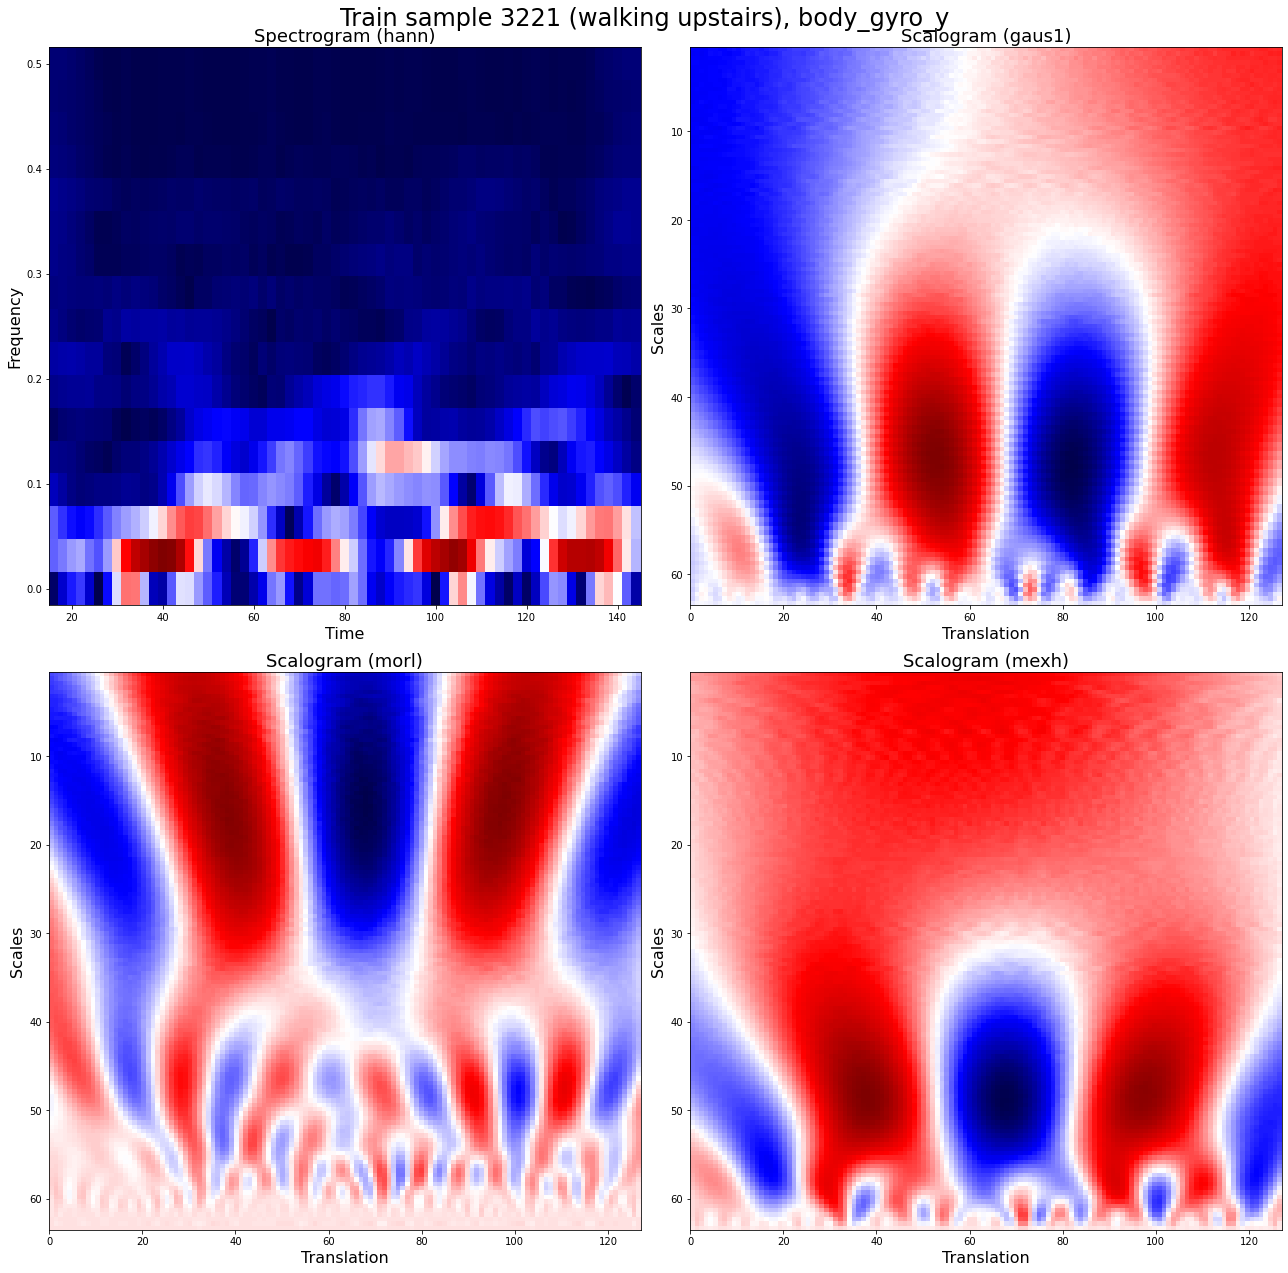

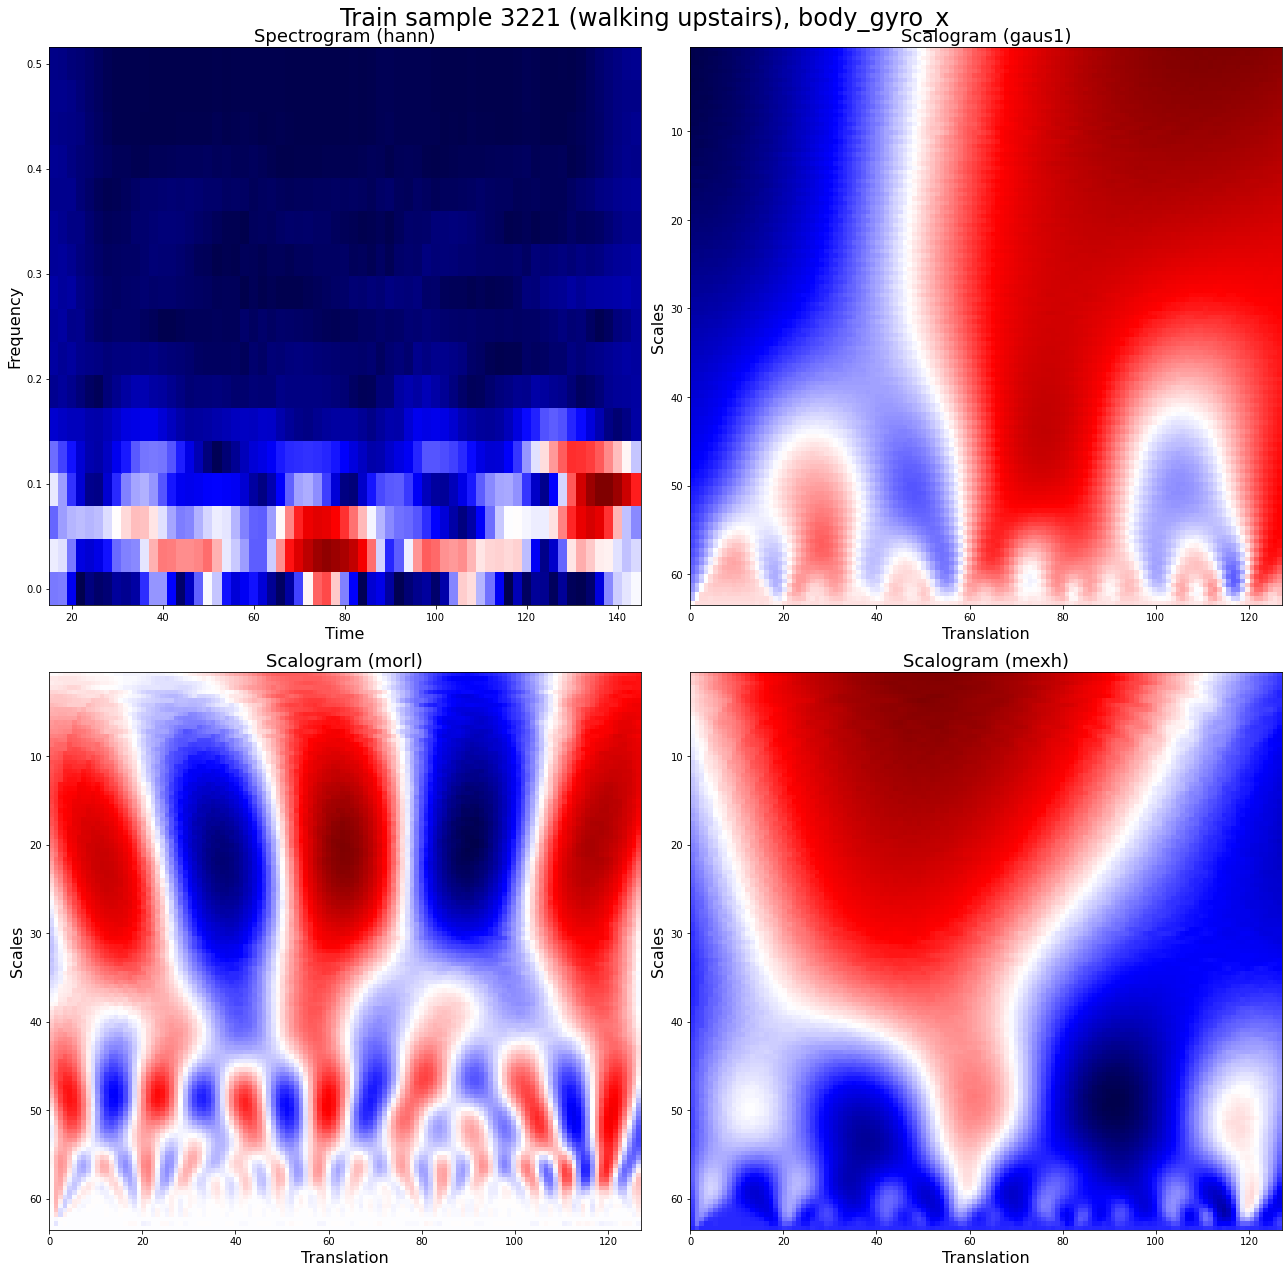

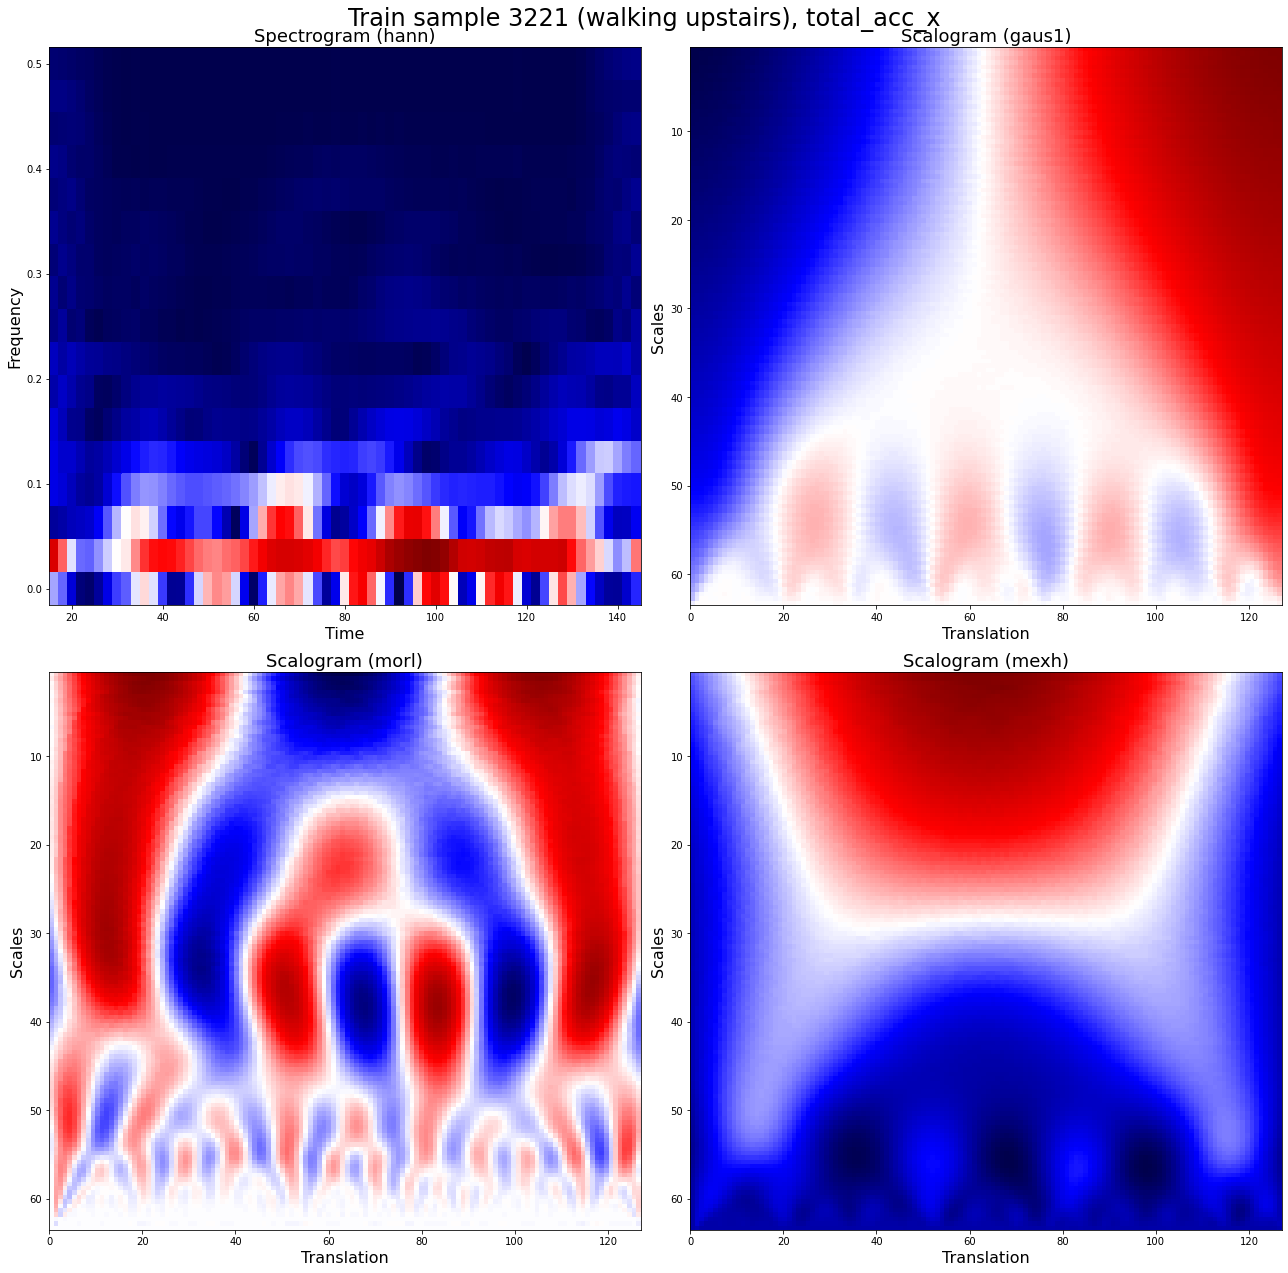

In [67]:
from numpy import log10, absolute as abs
from scipy.fftpack import dct,fft

def plot_spectrogram(ax, sig, M, noverlap, fs=1.0, windowname = ('hamming'),cmap = plt.cm.seismic):
    # get the window taps
    win = signal.get_window(windowname,M,False)
    # prefix/suffix
    pref = sig[-int(M/2):]*win[0:int(M/2)]
    suf = sig[0:int(M/2)]*win[-int(M/2):]

    sig = np.concatenate((pref, sig))
    sig = np.concatenate((sig,suf))
    f, t, mag = signal.spectrogram(sig, fs, window=win, nperseg=M, noverlap=noverlap,
                                  scaling='spectrum', mode='magnitude')
    ax.pcolormesh(t, np.flip(f), np.flip(mag,axis=0), shading='nearest',cmap=cmap)

def plot_cwt(ax, sig, wavelet, cmap=plt.cm.seismic):
    voices_per_octave = 8
    max_scale = 8
    begin_scale = 1/(2**1)
    scales = list(range(1,int((max_scale/begin_scale)*voices_per_octave)))
    scales = [begin_scale*float(x) for x in scales]
    coef,f = pywt.cwt(sig,scales,wavelet)
    #import pdb;pdb.set_trace()
    ax.matshow(np.flip(coef,axis=0), cmap=cmap, extent=[0,len(sig)-1,scales[-1],scales[0]], aspect='auto')
    ax.xaxis.set_ticks_position('bottom')
    
# Randomly choose 10 signals from the training set
sample_set = np.random.randint(len(train_signals),size=1)
# Choose 3 random components to analyze
rand_comp = np.random.randint(9,size=3)

wavelets=['gaus1','morl','mexh']
#wavelets=['gaus1']

# Parameters for spectrogram
win = 'hann'
M = 32
noverlap = M-2

for i,sig in enumerate(train_signals[sample_set]):
    ## Now we plot
    for c in rand_comp:
        fig, ax = plt.subplots(figsize=(18,18), nrows=2,ncols=2)
        fig.suptitle('Train sample {} ({}), {}'.format(sample_set[i],
            activities_description[train_labels[sample_set[i]]],INPUT_FILES_TRAIN[c][:11]),
                     fontsize=24)

        ax[0][0].set_title('Spectrogram ({})'.format(win), fontsize=18)
        plot_spectrogram(ax[0][0], sig[:,c], M, noverlap)
        ax[0][0].set_ylabel('Frequency', fontsize=16)
        ax[0][0].set_xlabel('Time', fontsize=16)

        curr_ax=1
        for w in wavelets:
            px,py = int(curr_ax/2), curr_ax-(2*int(curr_ax/2))
            plot_cwt(ax[px][py], sig[:,c], w)
            curr_ax += 1
            ax[px][py].set_title('Scalogram ({})'.format(w), fontsize=18)
            ax[px][py].set_ylabel('Scales', fontsize=16)
            ax[px][py].set_xlabel('Translation', fontsize=16)

        fig.tight_layout()


It is interesting to see the almost constant values at the beginning of the bior4.4 and sym4 wavelet coefficients for total_acc_* components for some of the signals. Those correspond to convolution of the signal with the largest scale of the wavelet at those translation values. In fact, comparing this phenomenon across 'walking', 'laying' and 'sitting' we can already see some marked differences in its extent (which could be a key differentiating feature for the classifier).
We can see in the FT and DCT plots that starting from frequency coefficient ~ $105/127\pi$ the content trails off. We don't discern any such cutoff in the DWT coefficients for the 

### Here we define the neural networks that we intend to use for classification

In [ ]:
# Use NN1 for input vectors of length 16 and longer
def NN1 (x_train, y_train, x_test, y_test, print_nn=False, verbosity=0):

    num_classes = 6

    batch_size = 16
    epochs = 128

    input_shape = np.shape(x_train)[1:]

    # convert the data to the right type
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')

    # convert class vectors to binary class matrices - this is for use in the
    # categorical_crossentropy loss below
    y_train = list(y_train)
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = list(y_test)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    model = Sequential()

    normalizer = preprocessing.Normalization()
    normalizer.adapt(x_train)

    model.add(keras.Input(shape=input_shape))
    model.add(normalizer)
    model.add(Conv1D(16, kernel_size=3, strides=2))
    #model.add(MaxPooling1D(3,strides=2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D(32, kernel_size=3))
    model.add(MaxPooling1D(3,strides=2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(64, kernel_regularizer=keras.regularizers.l1_l2(l1=5e-5,l2=5e-5)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(96, kernel_regularizer=keras.regularizers.l1_l2(l1=5e-4,l2=5e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(64, kernel_regularizer=keras.regularizers.l1_l2(l1=5e-5,l2=5e-5)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(16, kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5,l2=1e-5)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(num_classes, kernel_regularizer=keras.regularizers.l1_l2(l1=5e-5,l2=5e-5),\
                    activation='softmax'))

    if print_nn:
        model.summary()
        return
    
    model.compile(loss=keras.losses.categorical_crossentropy, 
                  optimizer=keras.optimizers.Adam(), 
                  metrics=['accuracy'])

    es = EarlyStopping(monitor='val_loss', verbose=0, patience=8)
    t_start = perf_counter()
    model.fit(x_train, y_train, batch_size=batch_size, 
              epochs=epochs, verbose=verbosity, 
              validation_data=(x_test, y_test), 
              callbacks=[history,es])
    t_stop = perf_counter()
    t_diff = t_stop-t_start

    #train_score = model.evaluate(x_train, y_train, verbose=0)
    test_score = model.evaluate(x_test, y_test, verbose=0)

    return test_score[0], test_score[1], t_diff, model

# Use NN2 for input vectors of length less than 16
def NN2 (x_train, y_train, x_test, y_test, print_nn=False, verbosity=0):

    num_classes = 6

    batch_size = 16
    epochs = 128

    input_shape = np.shape(x_train)[1:]

    # convert the data to the right type
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')

    # convert class vectors to binary class matrices - this is for use in the
    # categorical_crossentropy loss below
    y_train = list(y_train)
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = list(y_test)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    model = Sequential()

    normalizer = preprocessing.Normalization()
    normalizer.adapt(x_train)

    model.add(keras.Input(shape=input_shape))
    model.add(normalizer)

    model.add(Dense(16, kernel_regularizer=keras.regularizers.l1_l2(l1=1e-4,l2=1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(32, kernel_regularizer=keras.regularizers.l1_l2(l1=5e-4,l2=5e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(32, kernel_regularizer=keras.regularizers.l1_l2(l1=5e-4,l2=5e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(16, kernel_regularizer=keras.regularizers.l1_l2(l1=5e-4,l2=5e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Flatten())

    model.add(Dense(num_classes, kernel_regularizer=keras.regularizers.l1_l2(l1=1e-4,l2=1e-4),\
                    activation='softmax'))

    if print_nn:
        model.summary()
        return
    
    model.compile(loss=keras.losses.categorical_crossentropy, 
                  optimizer=keras.optimizers.Adam(), 
                  metrics=['accuracy'])

    es = EarlyStopping(monitor='val_loss', verbose=0, patience=8)
    t_start = perf_counter()
    model.fit(x_train, y_train, batch_size=batch_size, 
              epochs=epochs, verbose=verbosity, 
              validation_data=(x_test, y_test), 
              callbacks=[history,es])
    t_stop = perf_counter()
    t_diff = t_stop-t_start

    #train_score = model.evaluate(x_train, y_train, verbose=0)
    test_score = model.evaluate(x_test, y_test, verbose=0)

    return test_score[0], test_score[1], t_diff, model

### Generating the UCI-HAR features from DCT or DWT

In [ ]:
def get_uci_har_dwt_features(dataset, labels, waveletname, truncated_len=None):
    uci_har_features = []
    # Take the DWT of each component and concat them end-to-end
    for signal_no in range(0, len(dataset)):
        features = []
        for signal_comp in range(0,dataset.shape[2]):
            signal = dataset[signal_no, :, signal_comp]
            list_coeff = pywt.wavedec(signal, waveletname, mode='per')
            # convert the wavelet decomposition to array
            comp_dwt=[]
            end_flag=0
            for coeff in list_coeff:
                comp_dwt.extend(coeff)
            features.append(comp_dwt[:truncated_len])
        uci_har_features.append(features)
    X = np.array(uci_har_features).transpose(0,2,1)
    Y = labels
    return X, Y

def get_uci_har_dct_features(dataset, labels, truncated_len=None):
    uci_har_features = []
    # Take the DWT of each component and concat them end-to-end
    for signal_no in range(0, len(dataset)):
        features = []
        for signal_comp in range(0,dataset.shape[2]):
            signal = dataset[signal_no, :, signal_comp]
            coeff = dct(signal)[:truncated_len]
            features.append(list(coeff))
        uci_har_features.append(features)
    #print(np.shape(uci_har_features))
    X = np.array(uci_har_features).transpose(0,2,1)
    Y = labels
    return X, Y

In [ ]:
# Courtesy https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    f = plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    #plt.show()


### Now we run the classifiers in a loop of different truncation lengths of the input features

In [ ]:
import matplotlib.gridspec as gridspec

labels_arr=list(activities_description[k] for k in activities_description.keys())

#lengths = [2,4,8,16,32,64,96,128]
lengths = [4,16,32,64,128]

fig_perf = plt.figure(figsize=(36,14))
spec = gridspec.GridSpec(ncols=2, nrows=1)
perf_left_ax = fig_perf.add_subplot(spec[0,0])
perf_right_ax = fig_perf.add_subplot(spec[0,1])
perf_left_ax.set_title('Accuracy',fontsize=26)
perf_right_ax.set_title('Loss',fontsize=26)

fig_time = plt.figure()
plt.title('Training time')

# DCT first
acc=[]
loss=[]
t=[]
for l in lengths:
    x_train, y_train = get_uci_har_dct_features(uci_har_signals_train, uci_har_labels_train, l)
    x_test, y_test = get_uci_har_dct_features(uci_har_signals_test, uci_har_labels_test, l)
    if l < 16:
        val_loss, val_acc, train_time, mdl = NN2(x_train, y_train, x_test, y_test)
    else:
        val_loss, val_acc, train_time, mdl = NN1(x_train, y_train, x_test, y_test)
    acc.append(val_acc)
    loss.append(val_loss)
    t.append(train_time)

    y_pred = np.argmax(mdl.predict(x_test),axis=1)
    cm = confusion_matrix(y_test,y_pred,labels=range(no_labels))
    plot_confusion_matrix(cm,labels_arr,title='DCT length {}'.format(l))
    
plt.figure(fig_perf.number)
perf_left_ax.plot(lengths,acc,label='dct')
perf_right_ax.plot(lengths,loss,label='dct')
plt.figure(fig_time.number)
plt.plot(lengths,t,label='dct')

# DWTs next
for w in wavelets:
    acc=[]
    loss=[]
    t=[]
    for l in lengths:
        x_train, y_train = get_uci_har_dwt_features(uci_har_signals_train, uci_har_labels_train, w,l)
        x_test, y_test = get_uci_har_dwt_features(uci_har_signals_test, uci_har_labels_test, w,l)
        if l < 16:
            val_loss, val_acc, train_time, mdl = NN2(x_train, y_train, x_test, y_test)
        else:
            val_loss, val_acc, train_time, mdl = NN1(x_train, y_train, x_test, y_test)
        acc.append(val_acc)
        loss.append(val_loss)
        t.append(train_time)

        y_pred = np.argmax(mdl.predict(x_test),axis=1)
        cm = confusion_matrix(y_test,y_pred,labels=range(no_labels))
        plot_confusion_matrix(cm,labels_arr,title='{} length {}'.format(w,l))

    plt.figure(fig_perf.number)
    perf_left_ax.plot(lengths,acc,label=w)
    perf_right_ax.plot(lengths,loss,label=w)
    plt.figure(fig_time.number)
    plt.plot(lengths,t,label=w)

plt.figure(fig_perf.number)
perf_left_ax.set_ylabel('Accuracy', fontsize=22)
perf_right_ax.set_ylabel('Loss', fontsize=22)
perf_left_ax.set_xlabel('Input length', fontsize=22)
perf_right_ax.set_xlabel('Input length', fontsize=22)
perf_left_ax.legend(fontsize=18)
perf_right_ax.legend(fontsize=18)

plt.figure(fig_time.number)
plt.xlabel('Input length')
plt.ylabel('Seconds')
plt.legend()

plt.show()


In [ ]:
# Let's try just the unprocessed time domain signals
'''
val_loss, val_acc, train_time = NN1(uci_har_signals_train, uci_har_labels_train, 
                                    uci_har_signals_test, uci_har_labels_test)
'''
x_train = uci_har_signals_train
y_train = uci_har_labels_train
x_test = uci_har_signals_test
y_test = uci_har_labels_test

val_loss, val_acc, train_time, mdl = NN1(x_train, y_train, x_test, y_test)
acc.append(val_acc)
loss.append(val_loss)
t.append(train_time)

y_pred = np.argmax(mdl.predict(x_test),axis=1)
cm = confusion_matrix(y_test,y_pred,labels=range(no_labels))
plot_confusion_matrix(cm,labels_arr,title='No preprocessing')

plt.show()


In [23]:
print(pywt.wavelist(kind='continuous'))

['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']


In [51]:
type(f)

NameError: name 'f' is not defined